In [103]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [104]:
load_dotenv()
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
dbname = os.getenv('DB_NAME')

DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"

engine = create_engine(DATABASE_URL)

In [105]:
df = pd.read_sql("SELECT * FROM data_ml", engine)

In [106]:
features = ["total_spent","avg_ticket","max_ticket","total_orders",
            "total_items","avg_items_per_order","unique_payment_types","first_last_difference_days","recency_days"]
df_features = df[features].copy()
df_features

,total_spent,avg_ticket,max_ticket,total_orders,total_items,avg_items_per_order,unique_payment_types,first_last_difference_days,recency_days
0,141.90,141.90,141.90,1,1,1.0,1,0,111
1,27.19,27.19,27.19,1,1,1.0,1,0,114
2,86.22,86.22,86.22,1,1,1.0,1,0,536
3,43.62,43.62,43.62,1,1,1.0,1,0,320
4,196.89,196.89,196.89,1,1,1.0,1,0,287
...,...,...,...,...,...,...,...,...,...
93352,2067.42,2067.42,2067.42,1,2,2.0,1,0,446
93353,84.58,84.58,84.58,1,1,1.0,1,0,261
93354,112.46,112.46,112.46,1,1,1.0,1,0,567
93355,133.69,133.69,133.69,1,1,1.0,1,0,118


In [107]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
total_spent,93357.0,165.198772,226.314579,9.59,63.06,107.78,182.56,13664.08
avg_ticket,93357.0,160.316648,219.572062,9.59,62.37,105.63,176.65,13664.08
max_ticket,93357.0,161.801052,221.287026,9.59,62.64,106.38,178.22,13664.08
total_orders,93357.0,1.033420,0.209099,1.00,1.00,1.00,1.00,15.00
total_items,93357.0,1.232205,0.819763,1.00,1.00,1.00,1.00,75.00
avg_items_per_order,93357.0,1.139511,0.527042,1.00,1.00,1.00,1.00,21.00
unique_payment_types,93357.0,1.026222,0.160731,1.00,1.00,1.00,1.00,3.00
first_last_difference_days,93357.0,2.634061,24.955954,0.00,0.00,0.00,0.00,633.00
recency_days,93357.0,236.936673,152.584315,0.00,113.00,218.00,345.00,694.00


In [108]:
# Se visualizan desviacion estandar y coef de variacion
stats = pd.DataFrame({
    "mean": df_features.mean(),
    "std": df_features.std(),
})

stats["cv"] = stats["std"] / stats["mean"]
stats.sort_values("cv", ascending=False)

,mean,std,cv
first_last_difference_days,2.634061,24.955954,9.474328
total_spent,165.198772,226.314579,1.369953
avg_ticket,160.316648,219.572062,1.369615
max_ticket,161.801052,221.287026,1.367649
total_items,1.232205,0.819763,0.665281
recency_days,236.936673,152.584315,0.643988
avg_items_per_order,1.139511,0.527042,0.462516
total_orders,1.033420,0.209099,0.202336
unique_payment_types,1.026222,0.160731,0.156624


In [109]:
# Se visualiza los valores skew para ver que tan sesgados estan
df_features.skew().sort_values(ascending=False)

total_items                   16.340405
first_last_difference_days    12.306065
total_orders                  11.095096
avg_ticket                     9.415274
max_ticket                     9.309544
total_spent                    9.210991
avg_items_per_order            7.625461
unique_payment_types           6.037977
recency_days                   0.447277
dtype: float64

In [110]:
# Se aplica escala logaritmica
cols_to_log = [
    "total_spent",
    "avg_ticket",
    "max_ticket",
    "total_orders",
    "first_last_difference_days",
    "total_items",
    "avg_items_per_order",
    "unique_payment_types"
]

for col in cols_to_log:
    df_features[col] = np.log1p(df_features[col])

In [111]:
# Valores estandarizados 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_features)

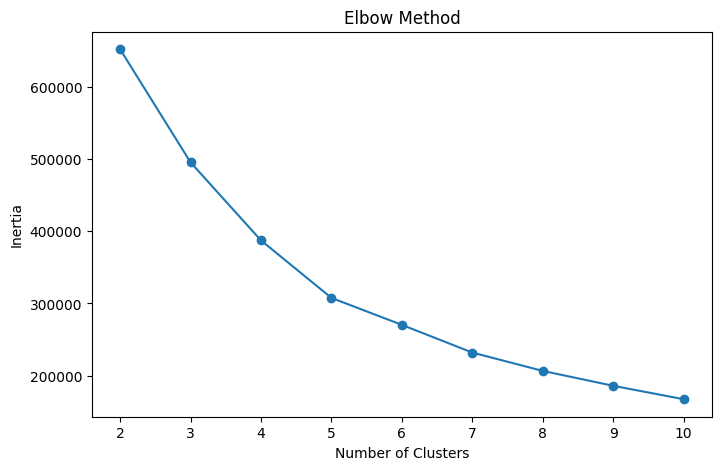

In [112]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [113]:
# Muestra aleatoria "10000"
sample_size = 10000
idx = np.random.choice(len(scaled_data), sample_size, replace=False)
sample_data = scaled_data[idx]

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(sample_data)
    score = silhouette_score(sample_data, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.3051
K=3, Silhouette Score=0.3230
K=4, Silhouette Score=0.3479
K=5, Silhouette Score=0.3736


*Tras evaluar los métodos del Codo y de la Silueta, los resultados indican que el número óptimo de clústeres es K=2. No obstante, con el objetivo de extraer insights más valiosos y obtener una segmentación más variada, se optará por utilizar K=4*

In [114]:
# Configuracion de numero de K
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)
# Nueva columna "cluster" añadida en el df original
df["cluster"] = cluster_labels

In [115]:
# Preparacion de datos para visualizacion T-SNE
sample_size = 10000
idx = np.random.choice(len(scaled_data), sample_size, replace=False)

sample_scaled = scaled_data[idx]
sample_clusters = df["cluster"].iloc[idx].values

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    max_iter=1000
)

tsne_results = tsne.fit_transform(sample_scaled)

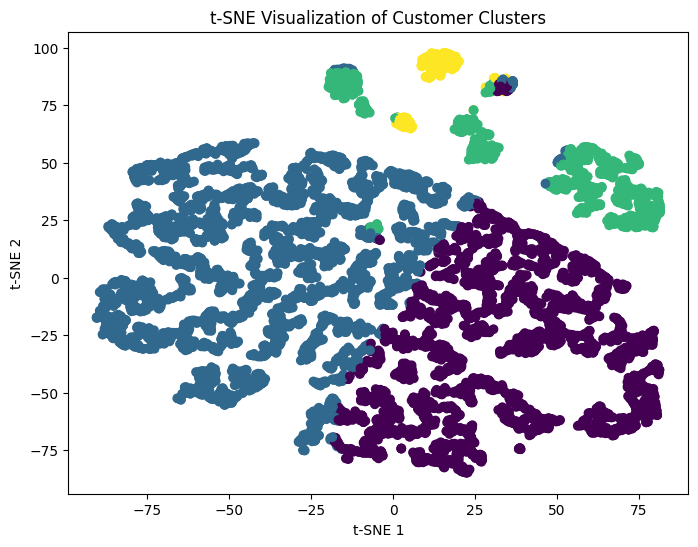

In [116]:
# Visualizacion de clusters con T-SNE
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    tsne_results[:,0],
    tsne_results[:,1],
    c=sample_clusters
)

plt.title("t-SNE Visualization of Customer Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [117]:
# Agrupacion de clusters y media de columnas numericas
cluster_profile = df.groupby("cluster")[features].mean()
cluster_profile

,total_spent,avg_ticket,max_ticket,total_orders,total_items,avg_items_per_order,unique_payment_types,first_last_difference_days,recency_days
cluster,,,,,,,,,
0,261.176055,259.533280,259.984422,1.008986,1.014216,1.000000,1.000000,0.000195,233.635026
1,63.902845,63.552710,63.612064,1.005990,1.020406,1.002235,1.004269,0.000134,239.950293
2,238.048372,234.201639,235.529366,1.020691,2.560247,2.171520,1.173298,0.001685,243.901414
3,318.126043,147.196809,200.251694,2.160382,2.804424,1.206783,1.204123,123.618401,191.412267


In [118]:
# Porcentajes de clientes en cada cluster
df["cluster"].value_counts(normalize=True) * 100

cluster
1    47.925705
0    38.502737
2    11.441027
3     2.130531
Name: proportion, dtype: float64

---

In [119]:
total = df["total_spent"].sum()
df.groupby("cluster")["total_spent"].sum()/total*100

cluster
0    60.872080
1    18.538811
2    16.486309
3     4.102800
Name: total_spent, dtype: float64

In [120]:
# Export de tabla con segmentacion añadida
df.to_sql("customer_segmentation", engine, if_exists="replace", index=False)

357

# Cluster Analysis

A continuación se presentan los insights estratégicos derivados del análisis de los clusters utilizando las métricas originales (sin escalar).

---

# Cluster 0 – High Ticket One-Time Buyers  
 38.50% de los clientes  
 60.87% del revenue total  

### Características:
- Alto **total_spent** (~261)
- **avg_ticket** elevado (~259)
- Aproximadamente 1 orden por cliente
- 1 ítem por orden
- Baja recurrencia (first_last_difference ≈ 0)
- Recency media (~233 días)

### Interpretación:
Este es el **motor financiero principal del negocio**.

Son clientes que realizan una compra de alto valor, pero no muestran comportamiento recurrente. El modelo actual depende fuertemente de este segmento.

### Insight estratégico:
Existe una gran oportunidad en convertir este segmento en recurrente. Incluso un pequeño aumento en frecuencia tendría un impacto significativo en ingresos.

---

# Cluster 1 – Low Value Mass Segment  
 47.93% de los clientes  
 18.54% del revenue total  

### Características:
- Bajo **total_spent** (~63)
- Ticket promedio bajo
- 1 orden por cliente
- 1 ítem por orden
- Sin recurrencia
- Mayor recency promedio (~239 días)

### Interpretación:
Es el segmento más grande en volumen, pero el menos relevante en términos de ingresos.

Son compradores de bajo ticket, probablemente sensibles a precio o compras puntuales.

### Insight estratégico:
Estrategias de cross-sell, bundles o incentivos a segunda compra podrían transformar parte de este segmento en clientes de mayor valor.

---

# Cluster 2 – High Basket Single Buyers  
 11.44% de los clientes  
 16.49% del revenue total  

### Características:
- Gasto medio-alto (~238)
- 1 orden por cliente
- Alto número de ítems por orden (~2.56)
- Mayor diversidad en métodos de pago
- Sin recurrencia significativa
- Mayor recency (~243 días)

### Interpretación:
Clientes que realizan una compra con múltiples productos en una sola transacción.

Indica intención fuerte de compra puntual, pero sin continuidad posterior.

### Insight estratégico:
Podrían responder bien a estrategias de recompra programada o remarketing post-compra.

---

# Cluster 3 – Repeat Buyers (Loyal Segment)  
 2.13% de los clientes  
 4.10% del revenue total  

### Características:
- Mayor número de órdenes (~2.16)
- Más ítems por cliente (~2.8)
- Mayor diversidad de pagos
- Alta diferencia entre primera y última compra (~123 días)
- Mejor recency (~191 días)

### Interpretación:
Es el único segmento con comportamiento realmente recurrente.

Aunque pequeño en volumen, representa el perfil más saludable en términos de relación con la marca.

### Insight estratégico:
Este segmento valida que existe potencial de fidelización en el negocio.  
El desafío es escalar este comportamiento al resto de la base de clientes.

---

# Conclusión General

El negocio está impulsado principalmente por compras de alto ticket pero baja recurrencia.

- El revenue depende de adquisición constante.
- La base recurrente es muy reducida.
- La mayor oportunidad estratégica está en aumentar frecuencia y retención.

La transición hacia un modelo con mayor recurrencia podría estabilizar ingresos y reducir dependencia de nuevos clientes.
